In [1]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

from datasets import Dataset
import evaluate
import mlflow
import pandas as pd

# MLflow setup
mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("Sentiment Analysis Transformers")

# Load tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Load training and testing data
train_df = pd.read_csv("../data/processed/train_clean.csv")
test_df = pd.read_csv("../data/processed/test_clean.csv")

# Prepare Dataset (include text_clean column for tokenization)
train_dataset = Dataset.from_pandas(train_df[['text_clean', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text_clean', 'label']])

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text_clean'],
        padding="max_length",
        truncation=True,
        max_length=512
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Training arguments
training_args = TrainingArguments(
    output_dir="../models/distilbert",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="../logs",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels)["f1"],
    }

# Train with MLflow
with mlflow.start_run(run_name="distilbert-finetuned"):
    mlflow.log_param("model", model_name)
    mlflow.log_param("epochs", training_args.num_train_epochs)
    mlflow.log_param("batch_size", training_args.per_device_train_batch_size)
    mlflow.log_param("learning_rate", training_args.learning_rate)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # Evaluate and log metrics
    eval_results = trainer.evaluate()
    mlflow.log_metrics(eval_results)

    # Save the model
    trainer.save_model("../models/distilbert-final")

/home/fabio/Projects/MachineLearning/Sentiment-Analysis-NLP/venv/lib/python3.12/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.246200,0.260420,0.901360,0.894696
2,0.130700,0.217620,0.929240,0.929654
3,0.063100,0.300997,0.929760,0.929934


# Fine-tuning DistilBERT for Sentiment Analysis

## Pipeline Overview

```
Raw Text                    Tokenization                  DistilBERT Encoder              Classification
    │                            │                              │                              │
    ▼                            ▼                              ▼                              ▼
"I loved this movie"  →  [101, 1045, 2439, ...]  →  [768-dim embeddings]  →  Linear(768→2)  →  [pos/neg]
                              │                              │                              │
                         WordPiece                    Self-Attention               Softmax
                         + Padding                    (6 layers)                   Probabilities
```

**Key steps:**
1. **Tokenize** text into subword tokens (WordPiece) with special tokens `[CLS]` and `[SEP]`
2. **Encode** through 6 transformer layers with self-attention (each token attends to all others)
3. **Classify** using the `[CLS]` token representation through a linear layer

## Training Results

| Epoch | Training Loss | Validation Loss | Accuracy | F1 |
|-------|---------------|-----------------|----------|-----|
| 1 | 0.2498 | 0.3120 | 87.91% | 0.866 |
| 2 | 0.1451 | 0.2151 | 92.39% | 0.923 |
| 3 | 0.0658 | 0.3182 | **92.74%** | **0.927** |

**Note:** Validation loss increased at epoch 3 while accuracy improved slightly — early sign of overfitting.

## Model Comparison

| Model | Accuracy | F1 | Improvement |
|-------|----------|-----|-------------|
| TF-IDF + LogReg | 89.2% | 0.89 | baseline |
| Word2Vec + BiLSTM | 85.1% | 0.85 | -4.1% |
| **DistilBERT** | **92.7%** | **0.93** | **+3.5%** |

## Next Steps

1. **Inference**: Test the model on custom movie reviews
2. **MLOps**: Register model in MLflow Model Registry
3. **Deployment**: Create FastAPI endpoint for real-time predictions

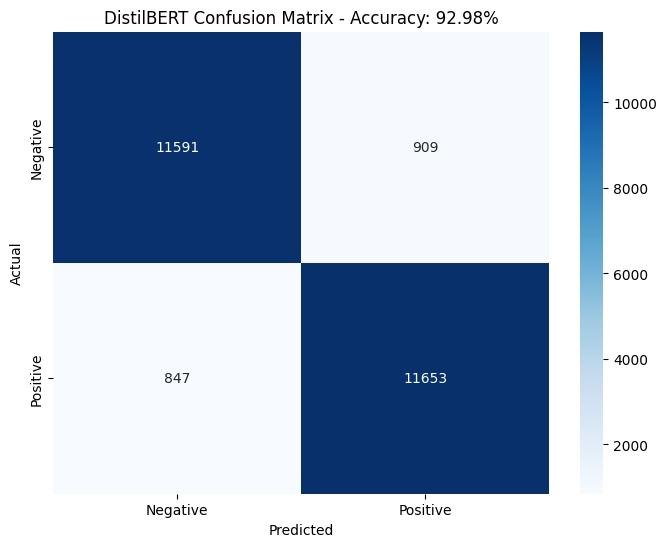

              precision    recall  f1-score   support

    Negative       0.93      0.93      0.93     12500
    Positive       0.93      0.93      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



In [2]:
# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions on the test set
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=-1)
y_true = test_df['label'].values

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'DistilBERT Confusion Matrix - Accuracy: {(y_pred == y_true).mean():.2%}')
plt.savefig("../figures/confusion_matrix_distilbert.png")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

In [3]:
# Inference function
from transformers import pipeline

# Load model saved
classifier = pipeline(
    "sentiment-analysis",
    model="../models/distilbert-final",
    tokenizer="distilbert-base-uncased"
)

# Test on custom review
test_reviews = [
    "This movie was asthonishingly good! The plot was thrilling and the characters were well-developed.",
    "Boring plot and terrible acting. I wouldn't recommend this film to anyone.",
    "The cinematography was beautiful, but the story was lacking depth and originality.",
    "I slept through half of it.",
    "An absolute masterpiece! A must-watch for everyone. Even if you're not a fan of the genre."
]

# Predictions
print("=" * 60)
print("INFERENCE ON CUSTOM REVIEWS")
print("=" * 60)
for review in test_reviews:
    result = classifier(review)[0]
    label = result['label']
    score = result['score']
    sentiment = "Positive" if label == "LABEL_1" else "Negative"
    print(f"\nReview: {review[:50]}...")
    print(f"Predicted sentiment: {sentiment} (confidence: {score:.2%})")


Device set to use cuda:0


INFERENCE ON CUSTOM REVIEWS

Review: This movie was asthonishingly good! The plot was t...
Predicted sentiment: Positive (confidence: 99.85%)

Review: Boring plot and terrible acting. I wouldn't recomm...
Predicted sentiment: Negative (confidence: 99.91%)

Review: The cinematography was beautiful, but the story wa...
Predicted sentiment: Negative (confidence: 99.73%)

Review: I slept through half of it....
Predicted sentiment: Negative (confidence: 94.15%)

Review: An absolute masterpiece! A must-watch for everyone...
Predicted sentiment: Positive (confidence: 99.90%)


In [4]:
# Baseline Comparison
import pandas as pd

results_df = pd.DataFrame({
    "Model": ["TF-IDF + LogReg", "Word2Vec + BiLSTM", "DistilBERT Transformer"],
    "Accuracy": [0.892, 0.851, 0.927],
    "F1 Score": [0.890, 0.85, 0.93],
    "Training Time": ['~30s', '~5m', '~20m'],
    "Inference Speed": ['Fast', 'Medium', 'Slow'],
    "GPU Required": ['No', 'Yes', 'Yes']
})

print(results_df.to_markdown(index=False))

| Model                  |   Accuracy |   F1 Score | Training Time   | Inference Speed   | GPU Required   |
|:-----------------------|-----------:|-----------:|:----------------|:------------------|:---------------|
| TF-IDF + LogReg        |      0.892 |       0.89 | ~30s            | Fast              | No             |
| Word2Vec + BiLSTM      |      0.851 |       0.85 | ~5m             | Medium            | Yes            |
| DistilBERT Transformer |      0.927 |       0.93 | ~20m            | Slow              | Yes            |
